Oftentimes in machine learning, our primary goal is to predict data labels, rather than numerical values.  Predicting labels is called *classification* (as opposed to predicting a continuous value, which is called *regression*).  However, the fundamental principles are the same: define a measure of misfit (or data likelihood, in the probabilistic context) and a model that allows the prediction of a label subject to some parameter choices, then tune those parameter choices to optimize the predictive accuracy with respect to a training dataset.  As one might expect, however, the choices of model and misfit are often different.

As an example dataset, we'll be using the [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set), which was first introduced by Ronald A. Fisher in 1936.  It provides four features: petal length, petal width, sepal length, and sepal width, along with a class label that divides the data into three classes: *Iris setosa, Iris virginica and Iris versicolor*.  It has since become a classic for testing machine learning algorithms, and is available in scikit-learn.  Let's import it and have a look:

(100, 4)


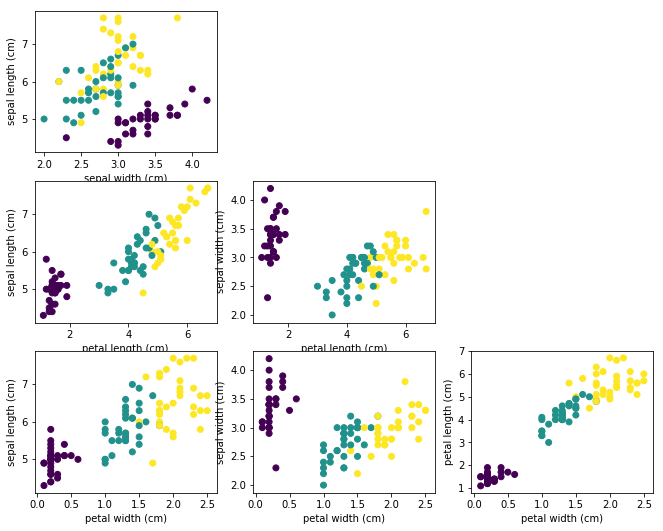

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [15,12]
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Load the dataset
iris = datasets.load_iris()
X = iris.data    # n x m matrix of features 
y = iris.target  # n vector of classes
X,X_test,y,y_test = train_test_split(X,y,test_size=0.33,random_state=42) # Split into 33% test and 67% training sets 
print(X.shape)
classes = [0,1,2] #Numeric class identifiers: 0 -> Setosa, 1-> Versicolor, 2-> Virginica

# 2D plots of all possible permutations of 2 features out of 4 produces 4 choose 2 plots
fig,axs = plt.subplots(nrows=4,ncols=4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(X[:,i],X[:,j],c=y)
            axs[i,j].set_xlabel(iris['feature_names'][i])
            axs[i,j].set_ylabel(iris['feature_names'][j])
        else: # delete redundant plots
            fig.delaxes(axs[i,j])
plt.show()


Here, we're going to construct a simple, but surprisingly effective classifier for the iris dataset based on Bayes' rule.  This method is called naive Bayes, for reasons that will become clear.  The method works in a two step processs: First, for a set of classes $C_k \in \{C_1,C_2,\ldots,C_N\}$, where $N$ is the number of possible class labels (3 in this case), use Bayes' rule to generate a probability that a data instance with a set of features $x$ belongs to each class, given a set of training data $D=(X,y)$.  In step two, assign the class label with the highest probability to that data instance.  For each class $C_k$, we can use Bayes' rule to determine the probability:
$$ 
P(C_k|\mathbf{x},D) \propto P(\mathbf{x}|D,C_k) P(C_k|D).
$$
However, this equation implies that we have to compute the joint probability of $\mathbf{x}$, where there could be some complicated correlations between features.  We can simplify this model by assuming that all of the features ($x_i \in \mathbf{X}$) are independent, or
$$ P(\mathbf{x}|D,C_k) \approx \prod_{j=1}^n P(x_j|D,C_k), $$
where $n$ is the number of features in a data instance.  This is the so-called *naive Bayes* assumption, naive because it assumes no correlation between features.  This leads to the simpler model:
$$
P(C_k|\mathbf{x},D) \propto P(C_k|D) \prod_{j=1}^n P(x_j|D,C_k).
$$

Now, we need to specify the distributions for the class prior $P(C_k|D)$ and class likelihoods $P(x_i|D,C_k)$.  We can model the prior probability as a Bernoulli distribution 
$$P(C=C_k|D) = \eta_k, $$
where $\eta_k$ is the probability that we would label the feature $\mathbf{x}$ as class $C_k$, before having seen any of the values in $\mathbf{x}$.  There are different options here.  We could say that all classes are equally likely, so $\eta=1/N$.  A more common practice is to estimate $\eta$ as the maximum likelihood value from the training data $D$, which for a Bernoulli distribution is 
$$
\eta = \frac{\sum_{i=1}^m [C = C_k]}{\sum_{i=1}^m},
$$
or the total proportion of the training data where the label is $C_k$.  Note the use of the [Iverson Bracket](https://en.wikipedia.org/wiki/Iverson_bracket) in the above definition.

For the likelihood, since we're considering continuous features, it makes sense to use a continous likelihood function.  While there are many options, a normal distribution should do the trick.  However, we need to use the training data to estimate the parameters of this normal distribution.  This is similar to what we did for the prior:
$$
P(x_j|C_k,D) = \int P(x_j|\mu_j,\sigma_j^2)\, P(\mu_j|C_k,D) \, P(\sigma_j^2|C_k,D) \;\mathrm{d}\mu_j\, \mathrm{d}\sigma_j^2.
$$
Assigning complete probability distributions to $\mu_j$ and $\sigma_j^2$ is the Bayesian thing to do, but leads to some complicated math and perhaps no analytical solution.  Instead, let's do what we did before and compute $\mu_j$ and $\sigma_j^2$ using maximum likelihood estimators, which for normally-distributed data are given by
$$
\mu_{j,MLE} = \frac{\sum_{i=1}^n x_{j,i} [C_i=C_k]}{\sum_{i=1}^n [C_i=C_k]},
$$
and 
$$
\sigma_{j,MLE}^2 = \frac{ (\sum_{i=1}^n (x_{j,i} - \mu_j)^2 [C_i=C_k])}{(\sum_{i=1}^n [C_i=C_k]) - 1},
$$
which are just the sample mean and sample variance of the training data examples for which the class is $C_k$.  As a brief aside, setting the parameter values in this way corresponds to assuming that
$$
P(\mu_j|C_k,D) = \delta(\mu_j - \mu_{j,MLE}(C_k,D))
$$
and 
$$
P(\sigma_j^2|C_k,D) = \delta(\sigma_j^2 - \sigma_{j,MLE}^2(C_k,D)),
$$
where $\delta$ is the [Dirac delta function]{https://en.wikipedia.org/wiki/Dirac_delta_function}.  This makes the integrals trivial and the likelihood function becomes:
$$
P(x_i|C_k,D) = \mathcal{N}(x_j|\mu_{j,MLE},\sigma_{j,MLE}^2).
$$
We can implement this in just a few lines in Python.  Begin by defining some count variables

In [4]:
m = X.shape[0]  # Number of data instances
m_test = X_test.shape[0] # Number of test data instances
N = 3           # Number of classes
n = X.shape[1]  # Number of features

m
m_test

50

For each class, we will need the $n$ values of $\mu_i$ and $\sigma_i^2$, let's define $n \times N$ arrays to hold these values, as well as the $N$ prior probabilities that we will need

In [5]:
mu_array = np.zeros((n,N))
sigma2_array = np.zeros((n,N))
prior_array = np.zeros((N))

Then we can compute these values by looping over the $N$ classes 

In [6]:
#Learning phase
for k in range(N):    #Loop over each class label
    C_k = classes[k]
    prior = sum(y==C_k)/float(y.shape[0])                           # Count the number of data where the label is C_k
    mu = np.sum(X[y==C_k],axis=0)/len(X[y==C_k])                    # Take the mean of those features where the corresponding label is C_k
    sigma2 = np.sum((X[y==C_k] - mu)**2,axis=0)/(len(X[y==C_k])-1)  # Take the variance of those features where the corresponding label is C_k
    mu_array[:,k] = mu                                              # Store in the arrays we created above
    sigma2_array[:,k] = sigma2
    prior_array[k] = prior
    
mu_array

array([[4.96451613, 5.85142857, 6.55294118],
       [3.36129032, 2.72571429, 2.97058824],
       [1.46774194, 4.22      , 5.54411765],
       [0.24516129, 1.30857143, 2.01176471]])

And that's it for the training phase.  Naive Bayes models, particularly when they compute the parameters of the likelihood model with maximum likelihood estimation are very efficient.  We can perform a similar loop over classes to make predictions.  First, let's compute the class probabilities for each entry in the training set:

In [9]:
# Training set predictions
class_probabilities = np.zeros((m,N))  # The probabilities for 

for i,x in enumerate(X):  # Loop over the training data instances
    for k in range(N):    # Loop over the classes
        prior = prior_array[k]
        mu = mu_array[:,k]
        sigma2 = sigma2_array[:,k]
        likelihood = np.prod(np.exp(-(x-mu)**2/(2*sigma2)))
        posterior_k = prior*likelihood
        class_probabilities[i,k] = posterior_k
        
class_probabilities /= np.sum(class_probabilities,axis=1,keepdims=True)
print(x, i)
print(class_probabilities[:,:])


[7.1 3.  5.9 2.1] 99
[[1.38215259e-068 9.98820691e-001 1.17930903e-003]
 [4.06603269e-239 4.54023784e-010 1.00000000e+000]
 [9.05126155e-087 9.64731041e-001 3.52689592e-002]
 [1.00000000e+000 1.17839247e-015 3.11078368e-023]
 [1.96683423e-240 1.57759821e-009 9.99999998e-001]
 [5.08035427e-056 9.99936045e-001 6.39549479e-005]
 [1.00000000e+000 3.74707516e-015 7.72206371e-023]
 [1.00000000e+000 4.79135355e-015 7.09702651e-023]
 [1.00000000e+000 6.78563929e-011 9.26677934e-018]
 [7.16977059e-037 9.99999453e-001 5.46969519e-007]
 [1.14181401e-120 6.18377721e-002 9.38162228e-001]
 [1.00000000e+000 2.31414968e-012 1.40150810e-019]
 [1.00000000e+000 2.37809396e-013 2.24216342e-021]
 [9.99999997e-001 2.87554576e-009 4.60833552e-017]
 [1.03166287e-068 9.99384249e-001 6.15750641e-004]
 [1.00000000e+000 7.09065047e-015 1.73771553e-022]
 [8.14260522e-065 9.99314076e-001 6.85924023e-004]
 [1.80909669e-251 2.40686846e-012 1.00000000e+000]
 [1.00000000e+000 2.67039791e-015 2.70659905e-023]
 [6.986852

Now we can classify by finding the class with the highest probability

In [37]:
y_pred_train = np.argmax(class_probabilities,axis=1)
y_pred_train


array([1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0,
       2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 2, 0, 2, 0, 0, 2, 1, 2, 2, 2,
       2, 1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 0, 2,
       1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 2, 2, 2,
       1, 2, 1, 1, 2, 2, 0, 1, 1, 0, 1, 2])

In [38]:
y

array([1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0,
       2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2,
       2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2,
       1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 2,
       1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

A nice way to look at classification accuracy is with a confusion matrix.  Its entries $p,q$ are just counts corresponding to the predicted class (row) versus the true class (column):

In [39]:
cm_train = confusion_matrix(y,y_pred_train)
print cm_train
print "training accuracy:", 1 - sum(abs(y-y_pred_train))/float(m)


[[31  0  0]
 [ 0 30  5]
 [ 0  2 32]]
training accuracy: 0.9299999999999999


We can do the same things for the test set:

In [40]:
# Test set predictions
class_probabilities = np.zeros((m_test,N))

for i,x in enumerate(X_test):
    for k in range(N):
        prior = prior_array[k]
        mu = mu_array[:,k]
        sigma2 = sigma2_array[:,k]
        likelihood = np.prod(np.exp(-(x-mu)**2/(2*sigma2)))
        posterior_k = prior*likelihood
        class_probabilities[i,k] = posterior_k

class_probabilities /= class_probabilities.sum(axis=1,keepdims=True)
y_pred_test = np.argmax(class_probabilities,axis=1)

cm_test = confusion_matrix(y_test,y_pred_test)
print cm_test
print "test accuracy:", 1 - sum(abs(y_test-y_pred_test))/float(m_test)


[[19  0  0]
 [ 0 13  2]
 [ 0  0 16]]
test accuracy: 0.96


Finally, let's plot the data as we did above, but this time highlight the misclassified features

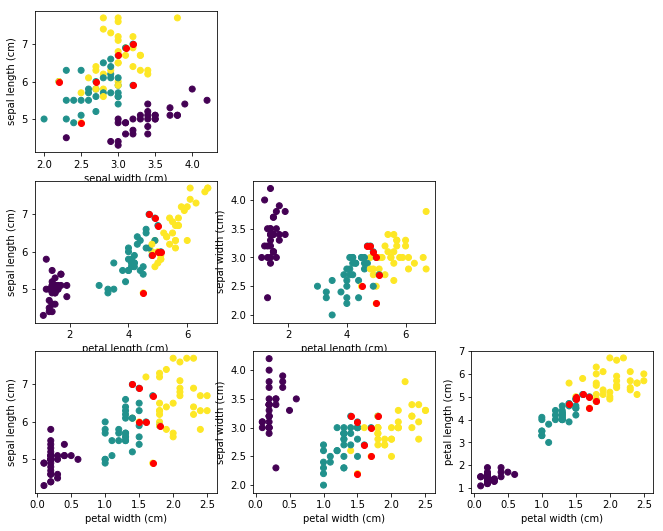

In [41]:
# 2D plots of all possible permutations of 2 features out of 4 produces 4 choose 2 plots
fig,axs = plt.subplots(nrows=4,ncols=4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(X[:,i],X[:,j],c=y)
            axs[i,j].plot(X[y!=y_pred_train,i],X[y!=y_pred_train,j],'ro')
            axs[i,j].set_xlabel(iris['feature_names'][i])
            axs[i,j].set_ylabel(iris['feature_names'][j])
        else: # delete redundant plots
            fig.delaxes(axs[i,j])
plt.show()

Not so surprisingly, the misclassifications fall near the boundaries between classes.  The great thing about Naive Bayes is that it works better as the dimensionality of the features increases, because overlaps in feature space become exponentially less common.